# Joint-space distance sampling for a complex joint
This notebook demonstrates how to sample the collision distance for pairs of bodies near a complex joint. The distance is first sampled with a standard collision library (FCL), then the collision is characterized thanks to a surface in configurations space; the collision distance is then recomputed in joint-space relatively to the previously defined surface.

The method is demonstrated here for the leg-body pairs of the Solo 12 robot. 
Let's first import the relevant libraries :

In [1]:
from collision_sampling.articular_space_coll_sampling import *
from collision_sampling.articular_space_coll_visualization import *

## Loading the model 
We have access to the Solo 12 model through Pinocchio and the `example_robot_data` package.

In [2]:
from example_robot_data import loadSolo

We will first define a very simple wrapper around the `example_robot_data` model loader, which will allow us to define the collision pairs we want to characterize. Here, we will first consider the shoulder collision pair (upper leg - body), and then take also the lower leg-body pair into account. These pairs are both added to the model for the front-left leg only, and the results can then be generalized by symetry. 

In [3]:
# Initialize SOLO12 model with the 2 collisions pairs of the FL shoulder
def initSolo():
    robot = loadSolo(solo=False)
    # Get robot model, data, and collision model
    rmodel = robot.model
    rdata  = rmodel.createData()
    gmodel = robot.collision_model

    # Get the base_link and FL_UPPER_LEG geometries
    base_link_geom = gmodel.getGeometryId("base_link_0")
    upper_leg_geom = gmodel.getGeometryId("FL_UPPER_LEG_0")
    lower_leg_geom = gmodel.getGeometryId("FL_LOWER_LEG_0")
    
    # Add the collision pairs to the geometric model
    gmodel.addCollisionPair(pio.CollisionPair(base_link_geom, upper_leg_geom))
    gmodel.addCollisionPair(pio.CollisionPair(base_link_geom, lower_leg_geom))

    gdata = gmodel.createData()
    return robot, rmodel, rdata, gmodel, gdata

We can now load the Solo 12 model with its shoulder collision pairs active :

In [4]:
robot, rmodel, rdata, gmodel, gdata = initSolo()

## Sampling parameters
Now that our robot collision model is defined, we need to sample the collision in configurations space. Our library is basically a wrapper around the `hpp-fcl` package, which simplifies the sampling process to the choice of the following parameters : 
- configuration subspace to sample (i.e. selection of the relevant DoF for the considered pairs, in the form of their indices in the kinematic model)
- joint-range for each selected joint
- *(if grid sampling)* sampling resolution for each joint
- collision pairs (indices in the geometric model)

We also need a reference configuration for the DoF we do not sample for collision.

## Solo shoulder 2D characterization
We will first consider only the upper leg-body pair, linked by a complex 2-DoF mechanism rotating along the x and y axis. We thus need to consider only a 2D joint-space; the 2 joints are revolute and we will sample them in a \\([-\pi,\pi]\\) range. The reference configuration for the other joints is the zero configuration i.e. all legs extended and perpendicular to the body. 

Let's define those in code :

In [5]:
# Reference configuration
ref_config = np.zeros(robot.q0.shape)

# Shoulder DoF indices in the model
q_ind = [7,8]

# Initialize joints ranges to sample
q_x_rot_range = [-np.pi, np.pi]
q_y_rot_range = [-np.pi, np.pi]
q_ranges = [q_x_rot_range, q_y_rot_range]

# Collision pairs : only the first one is needed here
collisionPairs = [0]

# We can also facultatively define a sampling resolution 
q_samples = [200,200]

### FCL collision sampling
These parameters are used to generate a list of configurations that the collision library then goes through. This list of configurations can be generated as :
- random configurations in the limits determined by the joints ranges
- grid-aligned configurations determined by the joints ranges and sampling resolutions

In [6]:
# Generate a random list of 10 000 configurations
rand_config_list = generateRandomConfigs(10000, q_ind, q_ranges)

# Generate a 200x200 grid-aligned list of configurations
grid_config_list = generateGridConfigs(q_ind, q_ranges, q_samples)

For any list of configurations (other smarter sampling localizations could be chosen) and of relevant pairs, we can now sample the FCL collision distance in joint-space. *(We can chose either to get the real 3D distance or only perform a binary collision check; only the binary collision check is needed after, but we will compute the real distance for visualization).* This method is called as follows :

In [7]:
rand_samples_fcl_map = sampleFCLDistanceFromConfigList(ref_config, 
                                          q_ind, 
                                          rand_config_list, 
                                          collisionPairs, 
                                          rmodel, 
                                          rdata, 
                                          gmodel, 
                                          gdata, 
                                          computeDist=True)

grid_samples_fcl_map = sampleFCLDistanceFromConfigList(ref_config, 
                                          q_ind, 
                                          grid_config_list, 
                                          collisionPairs, 
                                          rmodel, 
                                          rdata, 
                                          gmodel, 
                                          gdata, 
                                          computeDist=True)

<FCL DIST. SAMPLING> Generated 10000 / 10000 dist. samples
<FCL DIST. SAMPLING> Generated 40000 / 40000 dist. samples


On the implementation side, the variables `rand_samples_fcl_map`,`grid_samples_fcl_map` are numpy arrays containing the values of the sampled joints and the distance result for each configuration. For example, the first line in the `grid_samples_fcl_map` has the values \\([-\pi, -\pi, 0]\\) because the \\([-\pi, -\pi]\\) configuration of the shoulder joints, the other ones being in the reference configuration, is a collision configuration.

In [8]:
grid_samples_fcl_map[0]

array([-3.14159265, -3.14159265,  0.        ])

The results can be visualized easily for 2D joint-spaces thanks to the small wrapper we also provide :

<IPython.core.display.Javascript object>


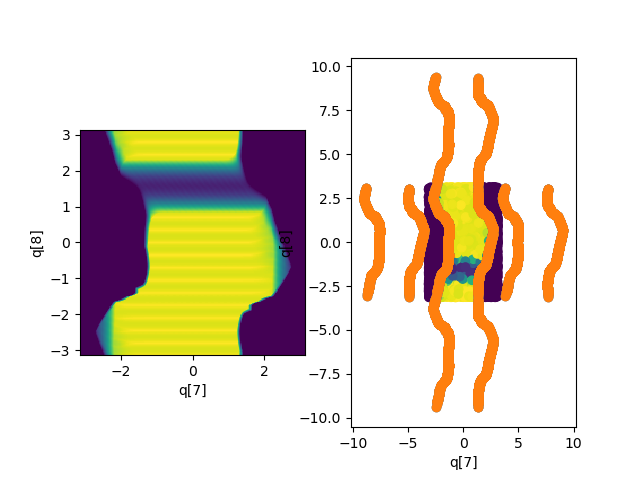

In [9]:
%matplotlib notebook

plt.subplot(1,2,1)
visualize2DData(grid_samples_fcl_map, q_ind, q_ranges, grid=True, q_steps=q_samples, cmap=plt.cm.viridis)
plt.subplot(1,2,2)
visualize2DData(rand_samples_fcl_map, q_ind, q_ranges, grid=False, cmap=plt.cm.viridis)

In the following, we only work on the grid-aligned sampling which contains more points, but everything is the same for the other dataset.

### Collision surface characterization
As described in more details in the paper, the usual distance we sampled here is not usable for control, and we need to redefine it as a joint-space distance. This is done by first sampling configurations on the collision surface where d(q) = 0, and then recomputing the distance to this surface in joint-space.

In [10]:
surf = boundaryRandomSapling(q_ind, 
                              q_ranges, 
                              2000,  #number of configurations in the resulting surface
                              1e-9, #(rad) precision of the dichotomy for each surface sample
                              ref_config, 
                              collisionPairs,
                              rmodel, 
                              rdata, 
                              gmodel, 
                              gdata, 
                              extend_periodic=True)

<BOUNDARY SAMPLING> Computed 2000 / 2000 boundary config.


The collision surface is returned as an array of subspace configurations. Let's simply plot them to verify if the surface seems uniformly sampled :

<IPython.core.display.Javascript object>


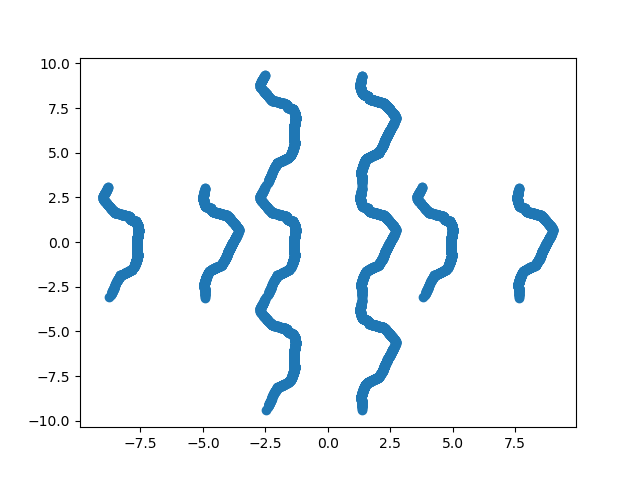

In [13]:
%matplotlib notebook

plt.scatter(surf[:,0], surf[:,1])

The `extend_periodic` argument in the call to sample the collision surface simply replicates the surface configurations samples around the central interval, so that the minimal distance to this set of configurations really represents the distance to the periodic collision surface. This is why the figure is a bit surprising at first if you set `extend_periodic=True`. However, it looks like 2000 configurations already are a good description in our case.

### Joint-space distance recomputation
The last step to obtain the redefined joint-space collision distance is to re-use the inital distance field sampled by FCL to assign a sign to the minimal distance between those configurations and the collision surface. 
\\[ d_S(q_R) = \min\limits_{q_S \in S} \ \{s_{coll}\|q_R - q_S\|\} \\]
with \\( s_{coll}(q) = 1 \\) when \\(q\\) is in free space and -1 otherwise.
We can also compute the collision distance jacobian as :
\\[ J(q) = \frac{q - q_w}{d(q)}\\]

In [14]:
# Convert spatial distance to joint-space distance
dist_metric = 'euclidean'
grid_samples_js_map = spatialToArticular(grid_samples_fcl_map, surf, batch_size=100, metric=dist_metric)

# Compute jacobian as well
grid_samples_js_jacobian = getSampledJac(grid_samples_js_map, surf, batch_size=100, metric=dist_metric)

<SPATIAL_TO_ARTICULAR> Converted 40000 / 40000 dist. samples to articular
<J> Computed 40000 / 40000 jac. samples


The results can be visualized with the same method as before :

<IPython.core.display.Javascript object>


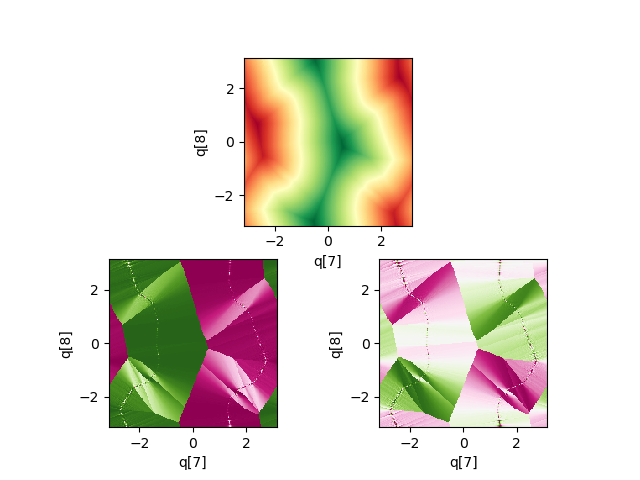

In [15]:
%matplotlib notebook

plt.subplot(2,1,1)
visualize2DData(grid_samples_js_map, q_ind, q_ranges, grid=True, q_steps=q_samples, cmap=plt.cm.RdYlGn)
plt.subplot(2,2,3)
visualize2DData(grid_samples_js_jacobian[:,[0,1,2]], q_ind, q_ranges, grid=True, q_steps=q_samples, cmap=plt.cm.PiYG)
plt.subplot(2,2,4)
visualize2DData(grid_samples_js_jacobian[:,[0,1,3]], q_ind, q_ranges, grid=True, q_steps=q_samples, cmap=plt.cm.PiYG)

And this is it ! We now have a complete dataset of collision distance and jacobian for given samples in the configuration subspace relevant for the 2D characterization of Solo shoulder collision pair. 

## Solo leg-body collision 3D characterization
We will now show how the collision pair between the lower leg and the body can be easily integrated in a very similar way by applying the same method in a 3D joint-space, taking the knee DoF into account. The crucial step is the parameters definition, after which the method calls are essentially the same. 3D visualization wrappers are also available.

The parameters for the enriched model are :

In [19]:
# Shoulder and knee DoF indices in the model
q_ind_3d = [7,8,9]

# Initialize joints ranges to sample
q_knee_rot_range = [-np.pi, np.pi]
q_ranges_3d = [q_x_rot_range, q_y_rot_range, q_knee_rot_range]

# Collision pairs : both pairs predefined in the geometric model are needed
collisionPairs_3d = [0,1]

# We can also facultatively define a sampling resolution 
# The number of configurations to sample can quickly grow in 3D, test first with low resolutions
q_samples_3d = [100,100,9] 

### FCL collision sampling
Here, the results are again demonstrated on grid-aligned samples.

In [20]:
# Generate a grid-aligned list of configurations
grid_config_3d_list = generateGridConfigs(q_ind_3d, q_ranges_3d, q_samples_3d)

# Sample FCL binary collision check without computing the exact distance to speed up computations
grid_samples_fcl_3d_map = sampleFCLDistanceFromConfigList(ref_config, 
                                          q_ind_3d, 
                                          grid_config_3d_list, 
                                          collisionPairs_3d, 
                                          rmodel, 
                                          rdata, 
                                          gmodel, 
                                          gdata, 
                                          computeDist=False)

<FCL DIST. SAMPLING> Generated 90000 / 90000 dist. samples


To visualize the results, we can either plot them directly in 3D with negative and positive parts split, or flatten them in the 3rd dimension.

<IPython.core.display.Javascript object>


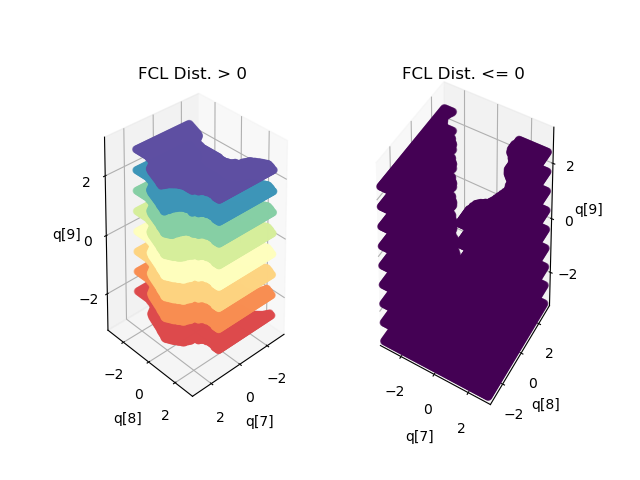

In [21]:
%matplotlib notebook

# 3D visualization    
FCL_viz = grid_samples_fcl_3d_map.copy()
FCL_viz[:,-1] = np.sign(FCL_viz[:,-1])*(FCL_viz[:,2] - np.min(FCL_viz[:,2]))
fig = plt.figure()
visualize3DData(fig, FCL_viz[np.where(FCL_viz[:,-1] > 0)], q_ind_3d, q_ranges_3d, grid=False, q_steps=q_samples_3d, subplot_pos=121, title="FCL Dist. > 0", cmap=plt.cm.Spectral)
visualize3DData(fig, FCL_viz[np.where(FCL_viz[:,-1] <= 0)], q_ind_3d, q_ranges_3d, grid=False, q_steps=q_samples_3d, subplot_pos=122, title="FCL Dist. <= 0", cmap=plt.cm.viridis)

<IPython.core.display.Javascript object>


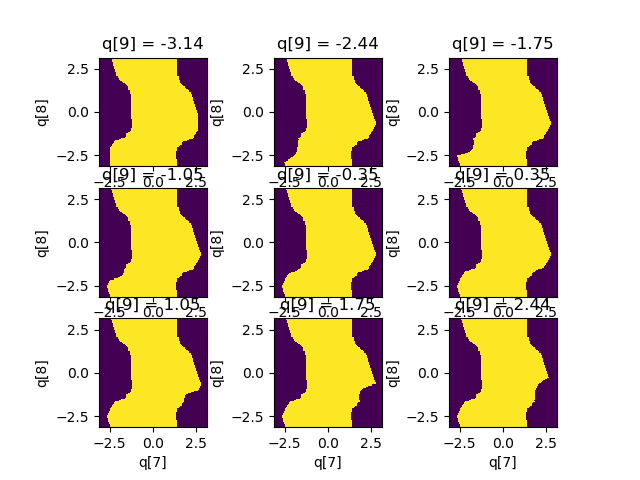

In [22]:
%matplotlib notebook

# Flattened visualization
visualizeFlat3DData(grid_samples_fcl_3d_map, q_ind_3d, q_ranges_3d, q_samples_3d, title="FCL distance", cmap=plt.cm.viridis)

### Collision surface characterization

In [23]:
surf_3d = boundaryRandomSapling(q_ind_3d, 
                              q_ranges_3d, 
                              5000,  #number of configurations in the resulting surface
                              1e-9, #(rad) precision of the dichotomy for each surface sample
                              ref_config, 
                              collisionPairs_3d,
                              rmodel, 
                              rdata, 
                              gmodel, 
                              gdata, 
                              extend_periodic=True)

<BOUNDARY SAMPLING> Computed 5000 / 5000 boundary config.


### Joint-space distance recomputation

In [24]:
# Convert spatial distance to joint-space distance
dist_metric = 'euclidean'
grid_samples_js_3d_map = spatialToArticular(grid_samples_fcl_3d_map, surf_3d, batch_size=100, metric=dist_metric)

# Compute jacobian as well
grid_samples_js_3d_jacobian = getSampledJac(grid_samples_js_3d_map, surf_3d, batch_size=100, metric=dist_metric)

<SPATIAL_TO_ARTICULAR> Converted 90000 / 90000 dist. samples to articular
<J> Computed 90000 / 90000 jac. samples


<IPython.core.display.Javascript object>


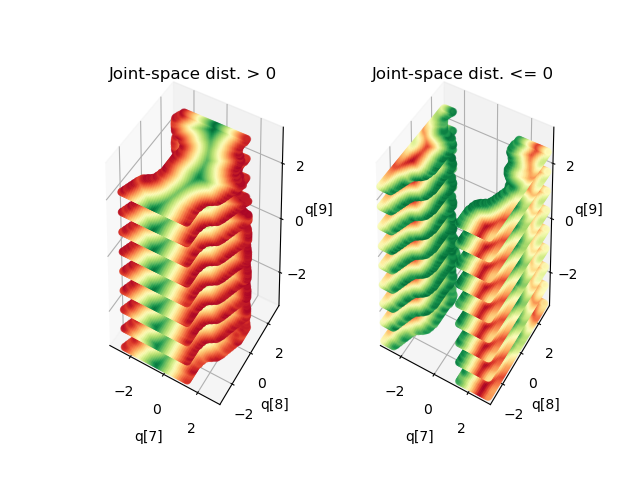

In [25]:
%matplotlib notebook
### Distance visualization
# 3D visualization    
js_viz = grid_samples_js_3d_map.copy()
fig = plt.figure()
visualize3DData(fig, js_viz[np.where(js_viz[:,-1] > 0)], q_ind_3d, q_ranges_3d, grid=False, q_steps=q_samples_3d, subplot_pos=121, title="Joint-space dist. > 0", cmap=plt.cm.RdYlGn)
visualize3DData(fig, js_viz[np.where(js_viz[:,-1] <= 0)], q_ind_3d, q_ranges_3d, grid=False, q_steps=q_samples_3d, subplot_pos=122, title="Joint-space dist. <= 0", cmap=plt.cm.RdYlGn, vmin=np.min(js_viz[:,-1]))

<IPython.core.display.Javascript object>


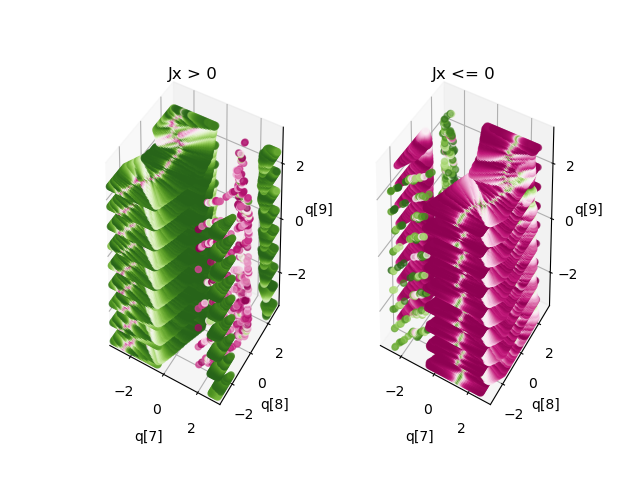

In [26]:
%matplotlib notebook
### Jacobians visualization
fig = plt.figure()

jac_x = grid_samples_js_3d_jacobian[:,[0,1,2,3]]
jac_y = grid_samples_js_3d_jacobian[:,[0,1,2,4]]
jac_z = grid_samples_js_3d_jacobian[:,[0,1,2,5]]

#Jx
visualize3DData(fig, jac_x[np.where(jac_x[:,-1] > 0)], q_ind_3d, q_ranges_3d, grid=False, q_steps=q_samples_3d, subplot_pos=121, title="Jx > 0", cmap=plt.cm.PiYG)
visualize3DData(fig, jac_x[np.where(jac_x[:,-1] <= 0)], q_ind_3d, q_ranges_3d, grid=False, q_steps=q_samples_3d, subplot_pos=122, title="Jx <= 0", cmap=plt.cm.PiYG, vmin=np.min(jac_x[:,-1]))
#Jy
#visualize3DData(fig, jac_y[np.where(jac_y[:,-1] > 0)], q_ind_3d, q_ranges_3d, grid=False, q_steps=q_samples_3d, subplot_pos=121, title="Jy > 0", cmap=plt.cm.PiYG)
#visualize3DData(fig, jac_y[np.where(jac_y[:,-1] <= 0)], q_ind_3d, q_ranges_3d, grid=False, q_steps=q_samples_3d, subplot_pos=122, title="Jy <= 0", cmap=plt.cm.PiYG, vmin=np.min(jac_y[:,-1]))
#Jknee
#visualize3DData(fig, jac_z[np.where(jac_z[:,-1] > 0)], q_ind_3d, q_ranges_3d, grid=False, q_steps=q_samples_3d, subplot_pos=121, title="Jkn > 0", cmap=plt.cm.PiYG)
#visualize3DData(fig, jac_z[np.where(jac_z[:,-1] <= 0)], q_ind_3d, q_ranges_3d, grid=False, q_steps=q_samples_3d, subplot_pos=122, title="Jkn <= 0", cmap=plt.cm.PiYG, vmin=np.min(jac_z[:,-1]))